In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info.states import Statevector, partial_trace
from qiskit.circuit import Gate
from qiskit.extensions import UnitaryGate
from scipy.linalg import expm, norm

import numpy as np
import random
import math
from numpy.fft import *
import matplotlib.pyplot as plt
import pandas as pd

## Required Definitions

In [3]:
n = 3 # reduction of system size, L to L/n
def u1():
    u1= QuantumCircuit(n+1, name='U1')
    for i in range(n):
        for j in range(i+1,n+1):
            u1.cz(i,j)
    u1= u1.to_instruction()
    return u1

In [34]:
def gell_mann_operator(size, coeff):
    symm = []
    antisymm = []
    diag = []
    operator = []
    n=size
    for i in range(1,n):
        for k in range(i):
            mat = np.zeros((n,n),dtype=np.complex_)
            mat[i][k] = mat[k][i] = 1
            symm.append(mat.copy())
            mat[i][k] = 1j; mat[k][i] = -1j
            antisymm.append(mat.copy())

    for i in range(1,n):
        mat = np.zeros((n,n),dtype=np.complex_)
        for k in range(i):
            mat[k][k] = 1
        mat[i][i] = -i
        mat = mat*(np.sqrt(2/(i*(i+1))))
        diag.append(mat.copy())
    matrices = symm + antisymm + diag
    #print(matrices)
    
    for c,m in zip(coeff,matrices):
        operator.append(c*m)
    return sum(operator)

In [5]:
def u2():
    u2=QuantumCircuit(n, name='U2')
    gate=UnitaryGate(expm(-1j*gell_mann_operator(2**n, coeff)))
    u2.append(gate, range(n))
    u2 = u2.to_gate()
    return u2

In [6]:
def p():
    p=QuantumCircuit(n, n-1, name='Pool')
    p.measure(range(n-1), range(n-1))
    for _ in range(n-1):
        p.z(n-1).c_if(_,1)
    p=p.to_instruction()
    return p

In [7]:
def qlist(j,n,l):
    qlist=[]
    for i in range(j,j+n):
        qlist.append(i%l)
    return qlist

In [8]:
def MSE(coeff):
    M = len(y)
    f = [network(init_state, coeff) for i in range(train_length)]
    MSE = (1/2*M)*sum((y[i] - f[i])**2 for i in range(M))
    return MSE

In [9]:
def training():
    eps = 1e-4
    eta = 10
    counter = 0
    diff = 1.0
    grad = np.zeros(len(coeff))
    while diff > 1e-5 or diff < -1e-5:
        counter+=1
        print('Iteration ongoing:', counter)
        print(r'$ \eta $ is:', eta)
        if diff < 0:
            eta+=0.05*eta
        elif diff > 0:
            eta-=0.5*eta

        MSE_old = MSE(coeff)
        for i in range(len(coeff)):
            grad[i]  = (MSE(coeff+eps) - MSE(coeff-eps))/(2*eps)

        for i in range(len(coeff)):
            coeff[i]-= eta*grad[i]

        MSE_new = MSE(coeff)
        diff = MSE_new - MSE_old

    print('Parameters are trained!')
    trained_coeff = coeff

In [28]:
def network(init_state, coeff):
    coeff = coeff
    qcnn = QuantumCircuit(l,4)

    qcnn.initialize(init_state, qcnn.qubits)
    qcnn.barrier()
    
    #Convolution----
    for j in range(0,l,n):
        qcnn.append(u1(),qlist(j,n+1,l))
    qcnn.barrier() 
    for j in range(0,l,n):
        qcnn.append(u2(),qlist(j,n,l))
    for j in range(0,l,n):
        qcnn.append(u2(),qlist(j+1,n,l))
    for j in range(0,l,n):
        qcnn.append(u2(),qlist(j+2,n,l))

    #Pooling-------
    qcnn.barrier() 
    # for j in range(0,l,n):
    #     qcnn.append(p,qlist(j,n,l))
    qcnn.h([1,2])
    qcnn.measure([1,2],[1,2])
    qcnn.z(0).c_if(2,1)
    qcnn.z(3).c_if(1,1)
    qcnn.barrier()

    #Fully Connected Layer----
    qcnn.cz(0,3)
    qcnn.h(0)
    qcnn.measure(0,0)
    qcnn.z(3).c_if(0,1)
    qcnn.h(3)
    qcnn.measure(3,3)
    qcnn.draw(output='mpl')
    # return qcnn
    
    # zero_state = Statevector.from_label('0000')
    # final_state = zero_state.evolve(qcnn)
    # reduced_state = partial_trace(final_state, [0, 1, 2])
    # plot_state_city(reduced_state.data)
    shots = 100
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qcnn, backend, shots = shots)
    counts = job.result().get_counts()
    
    prob_0 = []
    prob_1 = []
    for j in counts:
        if j[0] == '0':
            prob_0.append(counts[j])
        elif j[0] == '1':
            prob_1.append(counts[j])
    counts_final = {
        '0' : sum(prob_0)/shots,
        '1' : sum(prob_1)/shots
    }
    
    return counts_final['0']

## Convolutional Circuit

### Inputs

### Circuit Construction

In [12]:
np.random.seed(1024)
coeff = [2*np.pi*random.random() for i in range((2**n)**2-1)]
coeff = np.array(coeff)

In [29]:
#Add Training Data
#train_length = 

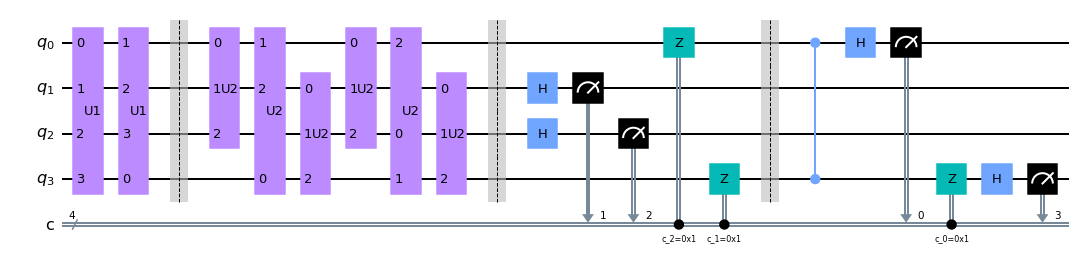

In [29]:
circ = network(init_state,coeff)
circ.draw(output='mpl')

In [ ]:
training()

Iteration ongoing: 1
$ \eta $ is: 10
Iteration ongoing: 2
$ \eta $ is: 5.0
Iteration ongoing: 3
$ \eta $ is: 2.5
Iteration ongoing: 4
$ \eta $ is: 2.625
Iteration ongoing: 5
$ \eta $ is: 2.75625
Iteration ongoing: 6
$ \eta $ is: 2.8940625
Iteration ongoing: 7
$ \eta $ is: 1.44703125
